# ⚽S4E1 - EDA & initial submission - Binary Classification with a Bank Churn Dataset 

Welcome to 2024! For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

## Evaluation

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Submission Format

For each id in the test set, you must predict the probability for the target variable Exited. The file should contain a header and have the following format:

```
id,Exited
0,0.9
1,0.1
2,0.5
etc.
```

## Data Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. 

# Code

## ToC

- [Imports](#Imports)


## Imports

/home/wiktor/.pyenv/versions/3.11.3/envs/kaggling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


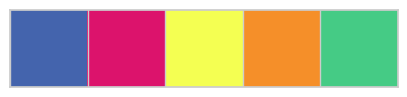

In [1]:
# essentials
import os
import pathlib
from copy import copy
import json

import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, TweedieRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer, roc_curve

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

# others
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb

import optuna
import shap

RANDOM_SEED = 64

palette = ["#4464ad", "#dc136c", "#F4FF52", "#f58f29","#45cb85"]

sns.set_theme(style="whitegrid")
sns.set_palette(palette)
sns.palplot(palette)

## Data loading & EDA

First we will check

1. Number and types of columns
2. Number of rows in train and test
2. Missing values
3. Target variable distribution

In [2]:
IN_KAGGLE = False

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
input_folder = kaggle_folder if IN_KAGGLE else local_folder

train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

GENERATED_COLUMN = True
ADD_ORIGINAL_DF = True

model_postfix = "_with_original" if ADD_ORIGINAL_DF else ""
model_postfix += "_generated" if GENERATED_COLUMN else ""

original_df = original_df.drop(columns=['RowNumber'])

# drop na rows from orignal df
original_df = original_df.dropna()

if GENERATED_COLUMN:
    train_df['generated'] = 1
    test_df['generated'] = 1
    original_df['generated'] = 0
    categorical_features.append('generated')
    
if ADD_ORIGINAL_DF:
    train_df = pd.concat([train_df, original_df])


for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    train_df = train_df.drop(columns=f)

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    df['Gender'] = df['Gender'].map({ "Male": 0, "Female": 1}).astype("bool")
    # encode geography
    df = pd.get_dummies(df, columns=['Geography'])

    return df

def feature_engineering_1(df):
    # Balance
    df['balance_over_100k'] = df['Balance'] >= 100000
    df['balance_over_150k'] = df['Balance'] >= 150000

    # EstimatedSalary
    df["estimated_salary_under_50k"] = df["EstimatedSalary"] < 50000
    df["estimated_salary_50k_to_100k"] = (df["EstimatedSalary"] >= 50000) & (df["EstimatedSalary"] < 100000)
    df["estamated_salary_over_150k"] = df["EstimatedSalary"] >= 150000

    # NumOfProducts
    df["num_of_products_3_or_4"] = df["NumOfProducts"] >= 3

    # Age
    df["age_over_40"] = df["Age"] >= 40
    df["age_over_50"] = df["Age"] >= 50
    df["age_over_60"] = df["Age"] >= 60

    new_features = [
        "balance_over_100k",
        "balance_over_150k",
        "estimated_salary_under_50k",
        "estimated_salary_50k_to_100k",
        "estamated_salary_over_150k",
        "num_of_products_3_or_4",
        "age_over_40",
        "age_over_50",
        "age_over_60",
    ]
    for f in new_features:
        df[f] = df[f].astype("int")

    return df

train_df = initial_feature_engineering(train_df)
train_df = feature_engineering_1(train_df)
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=target_col), train_df[target_col], test_size=0.2, random_state=RANDOM_SEED, stratify=train_df[target_col])

## Ideas for feature engineering

In [3]:
def create_pipeline(model, numeric_scalers=("scaler", StandardScaler())):
    numeric_pipeline = Pipeline(
        [numeric_scalers]
    )

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_features),
        #("categorical", categorical_pipeline, categorical_features),
    ], remainder='passthrough')

    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model),
    ])

def train_models(models, X_train, y_train, parameters={}):
    trained_models = {}
    for model_name, model in tqdm(models.items()):
        if model_name in parameters:
            model.set_params(**parameters[model_name])
        model = create_pipeline(model)
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

def evaluate_models(models, X_val, y_val):
    # create a dataframe with "model_name", "accuracy", "precision", "recall", "area under the ROC curve"
    results_df = pd.DataFrame(columns=["model_name", "accuracy", "precision", "recall", "auc"])

    for model_name, model in tqdm(models.items()):
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                "model_name": [model_name],
                "accuracy": [model.score(X_val, y_val)],
                "precision": [sklearn.metrics.precision_score(y_val, y_pred)],
                "recall": [sklearn.metrics.recall_score(y_val, y_pred)],
                "auc": [sklearn.metrics.roc_auc_score(y_val, y_proba)],
            })
        ])
    return results_df

def plot_roc_curve(models, X_val, y_val):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    palette_to_use = sns.color_palette("husl", len(models))
    # for each model, plot the roc curve in the same plot, with other color
    for i, (model_name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color=palette_to_use[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    # show legend
    ax.legend()


In [4]:
trained_models = {}

# generate random seed
models = {
    "xgboost": xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "lightgbm": lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1),
    "catboost": cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False, thread_count=16),
    #"knn": KNeighborsClassifier(n_jobs=-1),
    #"random_forest": RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    #"gradient_boosting": GradientBoostingClassifier(random_state=RANDOM_SEED),
    #"extra_trees": ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    #"bagging": BaggingClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    #"ada_boost": AdaBoostClassifier(random_state=RANDOM_SEED),
    #"sgd": SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1),
}

print("Training models...")

trained_models = {}
for model_name, model in tqdm(models.items()):
    model = create_pipeline(model)
    model.fit(X_train, y_train)
    trained_models[model_name] = model

#print("Evaluating models...")
#results_df = evaluate_models(trained_models, X_val, y_val)
#results_df.sort_values(by="auc", ascending=False)

Training models...


100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


In [6]:
! pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.5 MB/s eta 0:00:00a 0:00:01


## Oversampling

In [9]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as imPipeline

def create_oversampling_pipeline(model, numeric_scalers=("scaler", StandardScaler())):
    numeric_pipeline = Pipeline(
        [numeric_scalers]
    )

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_features),
        #("categorical", categorical_pipeline, categorical_features),
    ], remainder='passthrough')
    
    return imPipeline([
        ("resampler", RandomOverSampler(random_state=RANDOM_SEED)),
        ("preprocessor", preprocessor),
        ("classifier", model),
    ])


for model_name, model in tqdm(models.items()):
    model = create_oversampling_pipeline(model)
    model.fit(X_train, y_train)
    trained_models[model_name + "_randomoversampler_first"] = model

print("Evaluating models...")
results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

100%|██████████| 3/3 [00:18<00:00,  6.28s/it]


Evaluating models...


100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


,model_name,accuracy,precision,recall,auc
0,lightgbm_randomoversampler_first,0.815465,0.543405,0.789232,0.889360
0,catboost_randomoversampler_first,0.819493,0.551227,0.780979,0.887399
0,lightgbm,0.788185,0.499055,0.821429,0.886343
0,lightgbm_randomoversampler_second,0.788185,0.499055,0.821429,0.886343
0,xgboost_randomoversampler_first,0.819036,0.550910,0.773674,0.886171
0,catboost,0.797840,0.513716,0.798025,0.881058
0,catboost_randomoversampler_second,0.797840,0.513716,0.798025,0.881058
0,xgboost,0.563402,0.309114,0.864448,0.799849
0,xgboost_randomoversampler_second,0.563402,0.309114,0.864448,0.799849


In [ ]:
raise Exception("Stop here")

## Best params

In [ ]:
best_params_lightgbm = lightgbm_best_params
best_params_xgboost = xgboost_best_params
best_params_catboost = catboost_best_params

optuna_best_parameters_found = {
    "xgboost": xgboost_best_params,
    "lightgbm": lightgbm_best_params,
    "catboost": catboost_best_params,
}

optuna_best_parameters_found

## Submission

In [ ]:
import lightgbm

models = {
    "xgboost": xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "lightgbm": lightgbm.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1),
    "catboost": cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False),
    #"logistic_regression": LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    "knn": KNeighborsClassifier(n_jobs=-1),
    "stacked": StackingClassifier(
        [
            ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1, **xgboost_best_params)),
            ("lightgbm", lightgbm.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, **lightgbm_best_params)),
            ("catboost", cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False, **catboost_best_params)),
        ],
        final_estimator=LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
        n_jobs=-1,
    ),
}

trained_models = train_models(models, X_train, y_train, parameters=optuna_best_parameters_found)

In [ ]:
results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

In [ ]:
plot_roc_curve(trained_models, X_val, y_val)

# Submission

In [ ]:
train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

GENERATED_COLUMN = True
ADD_ORIGINAL_DF = True

model_postfix = "_with_original" if ADD_ORIGINAL_DF else ""
model_postfix += "_generated" if GENERATED_COLUMN else ""

original_df = original_df.drop(columns=['RowNumber'])

# drop na rows from orignal df
original_df = original_df.dropna()

if GENERATED_COLUMN:
    train_df['generated'] = 1
    test_df['generated'] = 1
    original_df['generated'] = 0
    categorical_features.append('generated')
    
if ADD_ORIGINAL_DF:
    train_df = pd.concat([train_df, original_df])


for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    train_df = train_df.drop(columns=f)
    test_df = test_df.drop(columns=f)

train_df = initial_feature_engineering(train_df)
train_df = feature_engineering_1(train_df)

test_df = initial_feature_engineering(test_df)
test_df = feature_engineering_1(test_df)

In [ ]:
# train model on train data
model = StackingClassifier(
    [
        ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1, **xgboost_best_params)),
        ("lightgbm", lightgbm.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, **lightgbm_best_params)),
        ("catboost", cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False, **catboost_best_params)),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    n_jobs=-1,
)
model = cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False, **catboost_best_params)
model = create_pipeline(model)
X_train = train_df.drop(columns=target_col)
y_train = train_df[target_col]
X_test = test_df

model.fit(X_train, y_train)

Use for comparison or blending with other predictions:

In [ ]:
# predict on test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


# create submission df

submission_df = pd.DataFrame({
    "id": test_df.index,
    target_col: y_proba
})
submission_df.to_csv("./submission.csv", index=False)
submission_df